<img src="https://bit.ly/2VnXWr2" width="100" align="left">

# Final project: NLP to predict Myers-Briggs Personality Type

## Imports

In [1]:
import re
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pkl

from sklearn.model_selection import train_test_split

import keras.metrics
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


## 4. Model building and evaluation: Deep Learning

In [2]:
spacy_nlp = spacy.load('en_core_web_sm')

In [3]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove_data/glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

### Using Types

In [5]:
mbti_df_clean = pd.read_pickle("data/output_pickles/mbti_clean_text.pkl")
result_umap_types  = pd.read_csv("data/output_csv/result_umap_types.csv")

In [6]:
mbti_df_clean.head()

,type,posts,type_clean,posts_clean,type_lemma,posts_lemma
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,infj,intj moments sportscenter plays pranks life ch...,infj,intj moment sportscent play prank life change ...
1,entp,'I'm finding the lack of me in these posts ver...,entp,finding lack posts alarming sex boring positio...,entp,find lack post alarming sex bore position exam...
2,intp,'Good one _____ https://www.youtube.com/wat...,intp,good course know blessing curse absolutely pos...,intp,good course know blessing curse absolutely pos...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",intj,dear intp enjoyed conversation day esoteric ga...,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,'You're fired.|||That's another silly misconce...,entj,fired silly misconception approaching logicall...,entj,fire silly misconception approach logically go...


In [7]:
result_umap_types.head()

,Unnamed: 0,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,...,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,0,infj,11.12,135.2900,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3.910143,7.477874
1,1,entp,23.40,187.4756,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.938040,5.939636
2,2,intp,16.72,180.6900,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3.740153,5.486389
3,3,intj,21.28,181.8324,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5.415134,7.452929
4,4,entj,19.34,196.4576,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2.083198,7.512875


In [8]:
labels = ["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp", "infj", "infp", "intj", "intp", "isfj", 
          "isfp", "istj", "istp"]
y = result_umap_types[labels].values
X = mbti_df_clean["posts_clean"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940,) (6940, 16) (1735,) (1735, 16)


In [10]:
X_train = list(X_train)

In [11]:
texts = [line for line in X_train] 

In [12]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [13]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 90265


In [14]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (6940, 200)
Shape of label tensor: (6940, 16)


In [15]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y_train[indices]

In [16]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

print ((x_train.shape),(y_train.shape),(x_val.shape),(y_val.shape))

(5552, 200) (5552, 16) (1388, 200) (1388, 16)


In [17]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [ 119  424  154  437   29   33   27   58  947 1178  738  809   99  171
  122  207]
validation:  [ 30 126  33 113   6   7   5  16 235 284 160 202  22  47  39  63]


In [18]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [  582 10742  3246  2058 10909  2294   214    15 10891   214    39  5162
    45 27765   105  1483   850 24429  2650    38 22890 21819  5045  1091
   443 26808  3173  1784 15266   858  2313  3550  2331  5275  6839 16780
    16   249    66  3720  1436 36382 69100     1    41   280    53     1
     2   189   903    49    28   143     5  2265   280 69101   655  1462
  1697    60   408  2175   395   463   484   339   126   151   397   101
    49  3774    18   643   616   669  9484   727   248  1216  2168  1139
   349  2582  3756  1334 13874   848 69102   907    19    93 69103    45
   710     7   473  6450  6293  1212 25382  8651   244   111   226  1586
  2646    12   395  4268 69104   225 34943   120  1295   777    93   102
  4648  6718    20  1217  5922  1958   538   356    21   123   105 44221
   172   240  3134  1563   141     8   113   113    80 35306  1391    68
  1647   252   895   244     1  1323 20481  3825    57  6119 69105    93
  2236    57   652    60   1

In [19]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="UTF-8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove_data/glove.6B/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [20]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [21]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(16, activation="softmax")(x)

In [22]:
model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          9026600   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

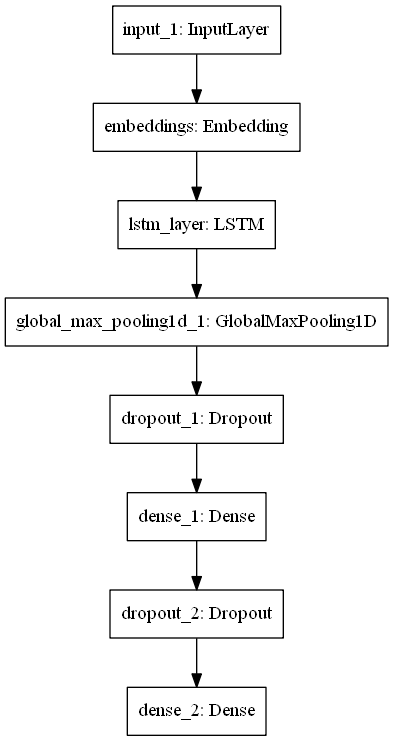

In [23]:
from keras.utils import plot_model
plot_model(model)

In [24]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 20, batch_size=32, validation_data=(x_val, y_val), verbose=2)

Training progress:
Train on 5552 samples, validate on 1388 samples
Epoch 1/20
 - 12s - loss: 2.3452 - accuracy: 0.2086 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 2.2298 - val_accuracy: 0.2687 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
 - 13s - loss: 2.1832 - accuracy: 0.2909 - precision_1: 0.5785 - recall_1: 0.0126 - val_loss: 2.0996 - val_accuracy: 0.3653 - val_precision_1: 0.7222 - val_recall_1: 0.0281
Epoch 3/20
 - 12s - loss: 2.0437 - accuracy: 0.3541 - precision_1: 0.6490 - recall_1: 0.0573 - val_loss: 1.9841 - val_accuracy: 0.4164 - val_precision_1: 0.7434 - val_recall_1: 0.0814
Epoch 4/20
 - 12s - loss: 1.9121 - accuracy: 0.4090 - precision_1: 0.7164 - recall_1: 0.1479 - val_loss: 1.8548 - val_accuracy: 0.4380 - val_precision_1: 0.7314 - val_recall_1: 0.1628
Epoch 5/20
 - 12s - loss: 1.8171 - accuracy: 0.4413 - precision_1: 0.7078 - recall_1: 0.2178 - val_loss: 1.8043 - val_accuracy: 0.4438 - val_precision_1: 0.6981 - val_recall_1: 0.20

In [25]:
hist_df = pd.DataFrame(history.history) 

hist_df.to_csv("data/output_csv/types_hist_df.csv")

In [10]:
types_hist_df = pd.read_csv("data/output_csv/types_hist_df.csv")
types_hist_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [11]:
types_hist_df['val_f1'] = ((types_hist_df["val_precision_1"]*types_hist_df["val_recall_1"])/
                           (types_hist_df["val_precision_1"]+types_hist_df["val_recall_1"]))

In [12]:
types_hist_df = types_hist_df[['val_loss', 'loss', 'val_accuracy', 'accuracy', 'val_precision_1', 'precision_1',
                  'val_recall_1', 'recall_1', 'val_f1']]
types_hist_df

,val_loss,loss,val_accuracy,accuracy,val_precision_1,precision_1,val_recall_1,recall_1,val_f1
0,2.229837,2.345194,0.268732,0.208573,0.000000,0.000000,0.000000,0.000000,NaN
1,2.099565,2.183186,0.365274,0.290886,0.722222,0.578512,0.028098,0.012608,0.027046
2,1.984147,2.043675,0.416427,0.354107,0.743421,0.648980,0.081412,0.057277,0.073377
3,1.854803,1.912099,0.438040,0.409042,0.731392,0.716405,0.162824,0.147875,0.133176
4,1.804313,1.817090,0.443804,0.441282,0.698068,0.707845,0.208213,0.217759,0.160377
5,1.758866,1.728842,0.471182,0.466859,0.754545,0.712891,0.239193,0.262968,0.181619
6,1.735749,1.672421,0.486311,0.490814,0.711155,0.722846,0.257205,0.278098,0.188889
7,1.714753,1.609404,0.476945,0.518732,0.681416,0.732959,0.277378,0.306016,0.197133
8,1.669762,1.543282,0.507925,0.536203,0.717472,0.737961,0.278098,0.331232,0.200415
9,1.663333,1.512892,0.506484,0.548631,0.680685,0.746796,0.314842,0.346362,0.215271


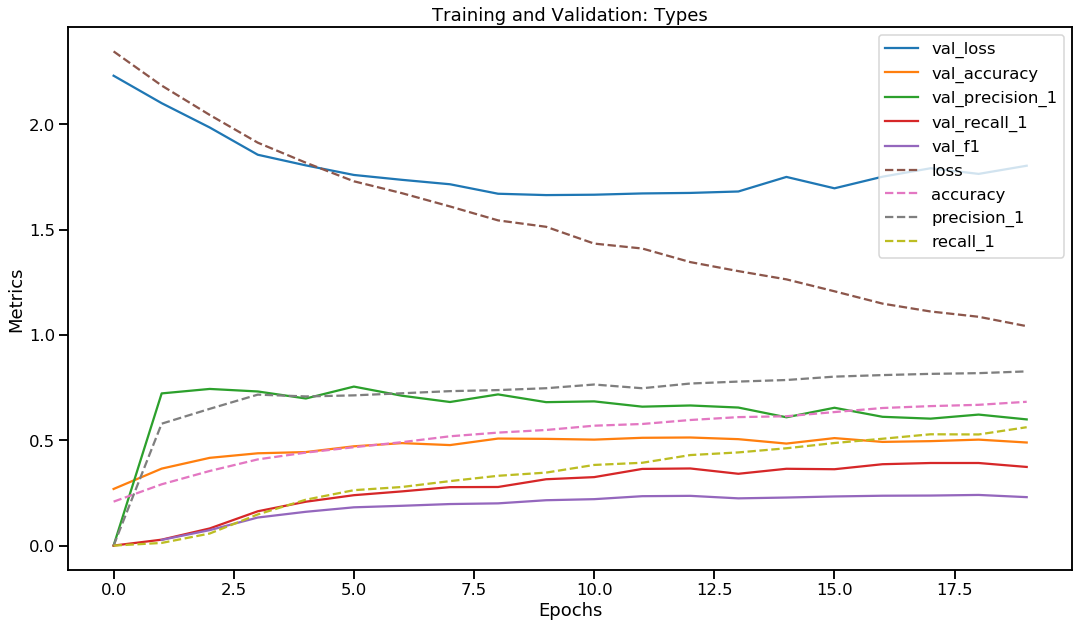

In [13]:
plt.figure(figsize=(18,10))
plt.plot(types_hist_df[['val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1']])
plt.plot (types_hist_df[['loss', 'accuracy', 'precision_1', 'recall_1']], '--')

plt.title('Training and Validation: Types')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1', 
            'loss', 'accuracy', 'precision_1', 'recall_1'])
plt.savefig("images/output_images/types_history.png")

sns.set_context("talk")
plt.show()

### Using dimensions

<img src="https://www.nicepng.com/png/detail/148-1486992_discover-the-most-powerful-ways-to-automate-your.png" width="1000"> 

In [31]:
raise SystemExit("Here it comes another quite consuming memory process. You should better not start it till everything else has itereated propperly")

SystemExit: Here it comes another quite consuming memory process. You should better not start it till everything else has itereated propperly

C:\Users\Miguel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
mbti_df_clean = pd.read_pickle("data/output_pickles/mbti_clean_text.pkl")
result_umap_dimensions  = pd.read_csv("data/output_csv/result_umap_dimensions.csv")

In [15]:
mbti_df_clean.head()

,type,posts,type_clean,posts_clean,type_lemma,posts_lemma
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,infj,intj moments sportscenter plays pranks life ch...,infj,intj moment sportscent play prank life change ...
1,entp,'I'm finding the lack of me in these posts ver...,entp,finding lack posts alarming sex boring positio...,entp,find lack post alarming sex bore position exam...
2,intp,'Good one _____ https://www.youtube.com/wat...,intp,good course know blessing curse absolutely pos...,intp,good course know blessing curse absolutely pos...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",intj,dear intp enjoyed conversation day esoteric ga...,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,'You're fired.|||That's another silly misconce...,entj,fired silly misconception approaching logicall...,entj,fire silly misconception approach logically go...


In [16]:
result_umap_dimensions.head()

,Unnamed: 0,type,words_per_comment,variance_of_word_counts,i-e,n-s,t-f,j-p,0,1
0,0,infj,11.12,135.2900,0,0,1,0,3.910143,7.477874
1,1,entp,23.40,187.4756,1,0,0,1,3.938040,5.939636
2,2,intp,16.72,180.6900,0,0,0,1,3.740153,5.486389
3,3,intj,21.28,181.8324,0,0,0,0,5.415134,7.452929
4,4,entj,19.34,196.4576,1,0,0,0,2.083198,7.512875


In [17]:
labels = ["i-e", "n-s", "t-f", "j-p"]
y = result_umap_dimensions[labels].values
X = mbti_df_clean["posts_clean"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940,) (6940, 4) (1735,) (1735, 4)


In [19]:
X_train = list(X_train)

In [20]:
texts = [line for line in X_train] 

In [21]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [22]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 90265


In [23]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (6940, 200)
Shape of label tensor: (6940, 4)


In [24]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y_train[indices]

In [25]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

print ((x_train.shape),(y_train.shape),(x_val.shape),(y_val.shape))

(5552, 200) (5552, 4) (1388, 200) (1388, 4)


In [26]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [1296  752 2993 3343]
validation:  [321 199 764 832]


In [27]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [    2    94   142   100     3 11634   897    77   478    13     3   559
   150   121   174   687     1   866     8    34  1337    43   210    45
   196  1959    73  2693     3   679  4340  1019   728 24236  2582  5009
   424  1019   499  3056 17195   188  1137 63429  6418  3130 21122 18481
   744 63430    50 10503 31195  5415   300  9492   363  9492   285   363
  9492    15  1432  2314     8  3406   487   681   483   128   229   244
    15 10848   196   191     3   482  1975    64     4  1697 10034  3070
  4591   373   246  5569   379 23958   449   191 15829    25    76   637
   373 11314   554   106   845  3483   482   340  4082   360   531   995
  1736   545   990   482    48  3360     1   689  1550   509    26  1060
  5018   181  1462  7078     1   405     4    96  1697    25   499  2767
   562   238   379  3279   670   399    13     5   764  6664   234   379
    44 14695   568   404  5055 10056 32494 17082 14432  1485  8235   553
   156  1165    68  2767  17

In [28]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="UTF-8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove_data/glove.6B/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [29]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [30]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(4, activation="softmax")(x)

In [31]:
model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          9026600   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

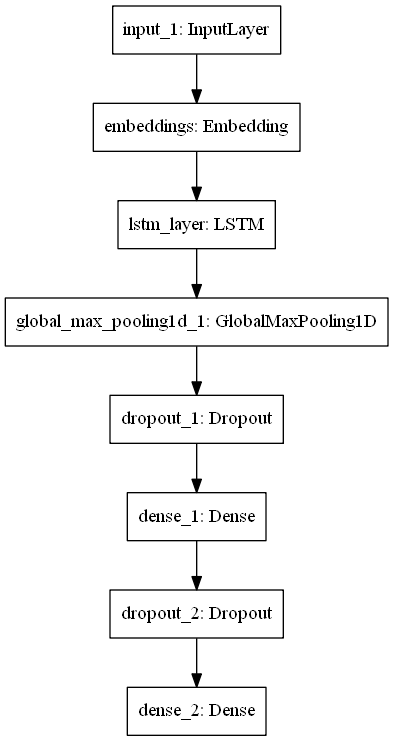

In [32]:
from keras.utils import plot_model
plot_model(model)

In [49]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 3, batch_size=32, validation_data=(x_val, y_val), verbose=2)

Training progress:
Train on 5552 samples, validate on 1388 samples
Epoch 1/3
 - 13s - loss: 3.4247 - accuracy: 0.2507 - precision_1: 0.5372 - recall_1: 0.2877 - val_loss: 2.1821 - val_accuracy: 0.3840 - val_precision_1: 0.5504 - val_recall_1: 0.3611
Epoch 2/3
 - 13s - loss: 2.6744 - accuracy: 0.2545 - precision_1: 0.5585 - recall_1: 0.2857 - val_loss: 3.6156 - val_accuracy: 0.1427 - val_precision_1: 0.5994 - val_recall_1: 0.3932
Epoch 3/3
 - 13s - loss: 2.8173 - accuracy: 0.2579 - precision_1: 0.5460 - recall_1: 0.2944 - val_loss: 3.3692 - val_accuracy: 0.3840 - val_precision_1: 0.5504 - val_recall_1: 0.3611


In [50]:
hist_df = pd.DataFrame(history.history) 

hist_df.to_csv("data/output_csv/dimensions_hist_df.csv")

In [51]:
dimensions_hist_df = pd.read_csv("data/output_csv/dimensions_hist_df.csv")
dimensions_hist_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [52]:
dimensions_hist_df['val_f1'] = ((dimensions_hist_df["val_precision_1"]*dimensions_hist_df["val_recall_1"])/
                                (dimensions_hist_df["val_precision_1"]+dimensions_hist_df["val_recall_1"]))

In [53]:
dimensions_hist_df = dimensions_hist_df[['val_loss', 'loss', 'val_accuracy', 'accuracy', 'val_precision_1', 'precision_1',
                  'val_recall_1', 'recall_1', 'val_f1']]
dimensions_hist_df

,val_loss,loss,val_accuracy,accuracy,val_precision_1,precision_1,val_recall_1,recall_1,val_f1
0,2.182103,3.424667,0.384006,0.250720,0.550432,0.537194,0.361059,0.287691,0.218037
1,3.615582,2.674422,0.142651,0.254503,0.599424,0.558535,0.393195,0.285663,0.237443
2,3.369249,2.817309,0.384006,0.257925,0.550432,0.546018,0.361059,0.294370,0.218037


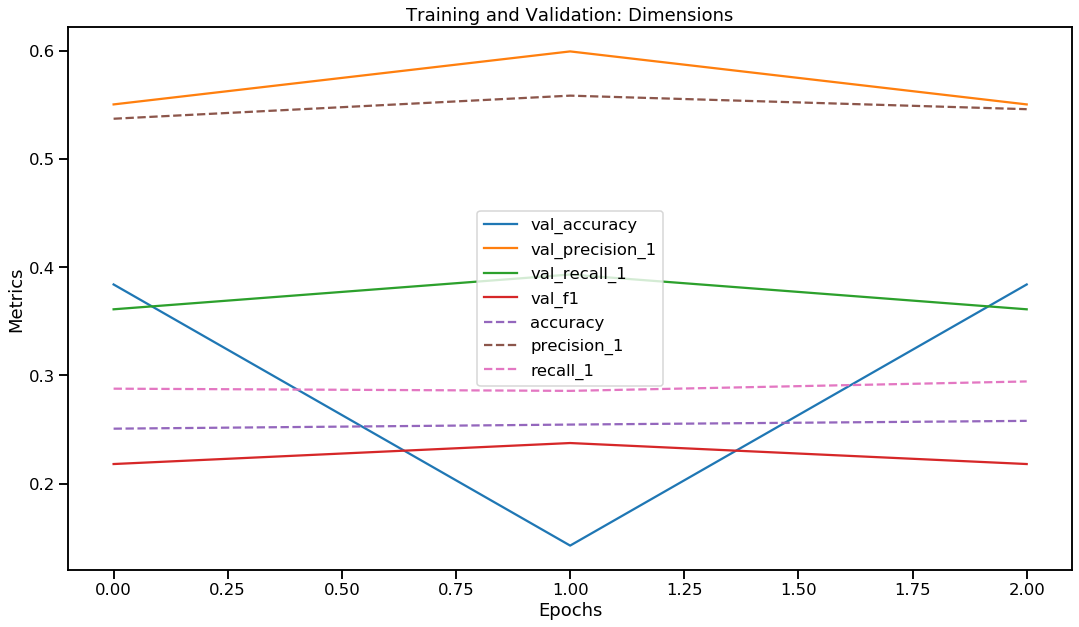

In [54]:
plt.figure(figsize=(18,10))
plt.plot(dimensions_hist_df[['val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1']])
plt.plot ( dimensions_hist_df[['accuracy', 'precision_1', 'recall_1']], '--' )

plt.title('Training and Validation: Dimensions')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(['val_accuracy', 'val_precision_1', 'val_recall_1', 'val_f1', 'accuracy', 'precision_1', 'recall_1'])
plt.savefig("images/output_images/dimensions_history.png")

sns.set_context("talk")
plt.show()

**Comments**

Best F1 Scores for both models, the one using types and the one using dimensions, are pretty much the seme, being 0.24 and 0.23 respectively, but are still much lower than the scores obtained using ML models.

**Need to check how to add posts lengths and number of words**